## PowerHitters Vs Hard Runners

We wanted to analyse 2 types of batsmen in IPL. The 'Power Hitters' (PH) and 'Hard Runners' (HR). 
We expect the PH have the following traits

1. High Boundary Percetage: They score higher percentage of their runs in 4s and 6s. They don't like to run 1s, and 2s.
2. High Dotball Percentage: They will eat more dot balls looking for the perfect delivery to hit a 4 or a 6.
3. High HitorMiss Ratio: Either they will tee off and score heavily or get our cheaply looking to score too early in their innings or without due respect to the condition or opponents. This is calculated as percent of innings with scores less than a third of the batsman's average or more that twice his average. 
4. High Strike Rate
5. Low(er) average - This last point is somewhat questionable. We shall see

We want to use a clustering algorithm to automatically cluster(classify) the batsmen into 2 clusters. We are hoping that our features mentioned hear are relevant enough for the clustering algorithm to create PH and HR clusters automatically without we providing any labels (Unsupervised learning)

In [12]:
# import libraries
import urllib.request, json 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
#load data
df = pd.read_csv("./IPL_Deliveries_Full.csv")
df.shape

(136598, 21)

In [5]:
#utility functions to be used later

#1. Build a dictionary of Matches player by each batsman
played = {}
def BuildPlayedDict(x):
    #print(x.shape, x.shape[0], x.shape[1])
    for p in x.batsman.unique():
        if p in played:
            played[p] += 1
        else:
            played[p] = 1

df.groupby('match_id').apply(BuildPlayedDict)

#2. utility function to build some aggregate stats
def trybuild(lookuplist, buildlist):
    alist = []
    for i in buildlist.index:
        try:
            #print(i)
            alist.append(lookuplist[i])
            #print(alist)
        except KeyError:
            #print('except')
            alist.append(0)
    return alist

In [6]:
#Build the Summarized dataset 'BatmanStats' to do further analysis
BatsmanStats = df.groupby('batsman').aggregate({'ball': 'count', 'batsman_runs': 'sum'})
BatsmanStats.rename(columns={'ball': 'balls', 'batsman_runs': 'runs'}, inplace=True)
BatsmanStats['strike_rate'] = BatsmanStats['runs']/BatsmanStats['balls'] * 100
BatsmanStats['matches_played'] = [played[p] for p in BatsmanStats.index]
BatsmanStats['average']= BatsmanStats['runs']/BatsmanStats['matches_played']
    
for r in df.batsman_runs.unique():
    lookuplist = df[df.batsman_runs == r].groupby('batsman')['batsman'].count()
    BatsmanStats[str(r) + 's'] = trybuild(lookuplist, BatsmanStats)


In [14]:
#Filter Top batsmen in the league (palyed atleast 15 games, with an average of atleast 15, 
# strike rate of atleast 110 ordered by #srike rate)
bs = BatsmanStats
tb = bs[(bs.average > 15) & (bs.matches_played > 15) & (bs.strike_rate > 110)].sort_values(['average'], ascending = False)[:100]

#We get 80 such batsmen in our top batsmen dataset
len(tb)

80

In [15]:
# 'Dimension 1 for our analysis - Boundary Percentage')
tb['boundary_pct'] =  ((tb['4s'] * 4 ) + (tb['6s']  * 6))/tb['runs']

#'Dimension 2 for our analysis - DotBall (0s) Percentage')
tb['dotball_pct'] =  tb['0s']/tb['balls']

#Dimension 3 - Hit or Miss ratio
dfTop = df[df.batsman.isin(tb.index)]
hitormiss = {}
def computehitormiss(x):
    for p in x.batsman.unique():
        runs = x.batsman_runs.sum()
        avg = tb.loc[p]['average']
        if((runs >= 2 * avg) | (runs <= 0.33 * avg)):
            if p in hitormiss:
                hitormiss[p] += 1
            else:
                hitormiss[p] = 1

dfTop.groupby(['batsman','match_id']).apply(computehitormiss)
tb['hitmiss_pct'] = [hitormiss[p]/tb.loc[p]['matches_played'] for p in tb.index]

In [16]:
# slice the dataset to select only those columns relevant to our analysis
tb_knn = tb.loc[:,('boundary_pct','dotball_pct','hitmiss_pct','average','strike_rate')]
tb_knn.head()

,boundary_pct,dotball_pct,hitmiss_pct,average,strike_rate
batsman,,,,,
LMP Simmons,0.649682,0.452756,0.318182,42.818182,123.622047
CH Gayle,0.764996,0.461017,0.483516,37.923077,146.228814
SE Marsh,0.615730,0.384840,0.475410,36.475410,129.737609
ML Hayden,0.675700,0.437426,0.312500,34.593750,131.942789
MEK Hussey,0.558422,0.390170,0.431034,34.086207,119.963592


In [17]:
# scale the features 
from sklearn import preprocessing
x = tb_knn.loc[:,('boundary_pct','dotball_pct','hitmiss_pct','average','strike_rate')].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

#append scaled columns
tb_knn['bpct_scaled'] = x_scaled[:,0]
tb_knn['db_scaled'] =x_scaled[:,1]
tb_knn['hm_scaled'] =x_scaled[:,2]
tb_knn['avg_scaled'] =x_scaled[:,3]
tb_knn['sr_scaled'] =x_scaled[:,4]

#build feature matrix
X_tb = tb_knn.drop(['boundary_pct','dotball_pct','hitmiss_pct','average','strike_rate'], axis=1)


### Clustering using Gausian Mixture Model (GMM)

GMM algorithm is a popular unsupervised clustering algorithm. We are using this on our scaled dataset to build 2 clusters. We are hoping that the clusters will broadly segment players as PH or HR. It is possible that there may be some noise that may confound this clustering. We shall see. 

In [18]:
from sklearn.mixture import GMM     

model = GMM(n_components=2, covariance_type='full') 
model.fit(X_tb)                    
tb_clusters = model.predict(X_tb)    
tb_knn['clusters'] =  tb_clusters


#### Sampling the Clusters

The clustering is complete. Lets sample the clusters here to see who is in them

1. Cluster - 0, has CH Gayle, ML Hayden, BB McCullum etc., This got to be the 'Power Hitters'
2. Cluster - 1, has V Kohli, A Rahane, SR Tendulkar. This got to the 'Hard Runners'. I wonder if we should name this cluster 'Complete Batsmen' instead. 

We will rename the clusters to help us in the visualization

In [27]:

print('Cluster - 0')
print('\n')
print(tb_knn[tb_knn.clusters == 0].head(15).index)

print('Cluster - 1')
print('\n')
print(tb_knn[tb_knn.clusters == 1].head(15).index)

#Renaming clusters
tb_knn.loc[tb_knn.clusters == 0,'clusters'] = 'Power Hitters'
tb_knn.loc[tb_knn.clusters == 1,'clusters'] = 'Hard Runners'



Cluster - 0


Index(['LMP Simmons', 'CH Gayle', 'ML Hayden', 'DA Warner', 'AB de Villiers',
       'SR Watson', 'Q de Kock', 'DR Smith', 'V Sehwag', 'BB McCullum',
       'AC Gilchrist', 'ST Jayasuriya', 'DA Miller', 'SS Iyer', 'TM Dilshan'],
      dtype='object', name='batsman')
Cluster - 1


Index(['SE Marsh', 'MEK Hussey', 'V Kohli', 'AM Rahane', 'SR Tendulkar',
       'SK Raina', 'F du Plessis', 'RG Sharma', 'G Gambhir', 'KP Pietersen',
       'S Dhawan', 'JP Duminy', 'A Symonds', 'SPD Smith', 'R Dravid'],
      dtype='object', name='batsman')


In [74]:
#Renaming columns for better readability
tb_knn.rename(columns={'boundary_pct':'boundary_percentage','dotball_pct':'dotball_percentage',
                      'hitmiss_pct':'hitormiss_percentage'}, inplace = True)

tb_knn.rename(columns={'bpct_scaled':'BoundaryPct_scaled',
                      'db_scaled':'DotBallPct_scaled',
                      'hm_scaled': 'HitorMissPct_scaled',
                      'avg_scaled': 'Average_scaled',
                      'sr_scaled': 'StrikeRate_scaled'},inplace=True)

### Visualizations

So here is where the fun will begin. We want to know how well our selected features such as Boundary_Percent, DotBall_Percent, HitOrMiss_Ratio, Average and Strike_Rate helped in segmenting the dataset the way we wanted. Which feature has performed better that the other and what has only added noise to the dataset. 

Any visualization of such dataset should start with Pair plot, Of Course

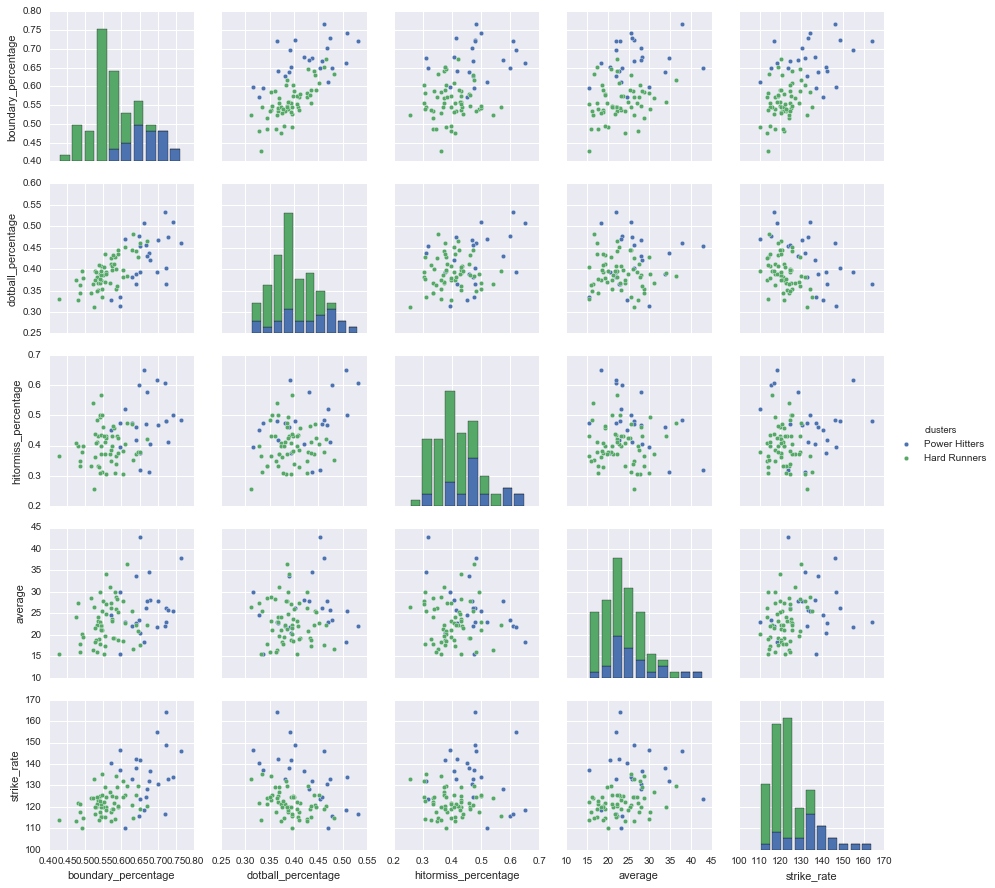

In [76]:
sns.pairplot(tb_knn.drop(['Average_scaled','StrikeRate_scaled','BoundaryPct_scaled','HitorMissPct_scaled','DotBallPct_scaled'], axis = 1),hue = "clusters", size=2.5) #, markers=["o", "s"])

**1. Boundary Percentage**:
    The clusters are nicely seperated by the Boundary Percentage. Of course as expected the PH score high percentage of their runs in 4s and 6s. Especially CH Gayle, who tops this metric with 76% of his runs in 4s and 6s. Can expect the big man to run can we? 

In [71]:
print("Batsmen with High Boundary Percentage - ",tb_knn.sort_values('boundary_percentage', ascending = False).head().index.values)

Batsmen with High Boundary Percentage -  ['CH Gayle' 'ST Jayasuriya' 'AC Gilchrist' 'V Sehwag' 'AD Russell']


**2. Dotball Percentage:**
    Dotball Percentage also seperates the clusters well. Although not as cleanly as Boundary Percentage. SPD Smith and AB de villiers eat up the least number of dotballs about 31% each. Although our clustering algorithm puts ABD in the Power Hitters cluster. Wow! that man can run as well as hit the long ball. He is a freak of nature. 

In [72]:
print("Batsmen with low Dotball Percentage - ", tb_knn.sort_values('dotball_percentage', ascending = True).head().index.values)

Batsmen with low Dotball Percentage -  ['SPD Smith' 'AB de Villiers' 'JP Duminy' 'DA Miller' 'DT Christian']


**3. HitorMiss Ratio:**
    This feature is somewhat a muddler looks like. Though the high end of this HitorMiss ratio is occupied by the PowerHitters. Actually GJ Maxwell is one of top with a hitmiss ratio of 62%. We always thought Maxi is all or nothing guy. Now we have data to prove it.

In [73]:
print('Top HitorMiss ratio -' , tb_knn.sort_values('hitormiss_percentage', ascending = False).head().index.values)

Top HitorMiss ratio - ['S Sohal' 'GJ Maxwell' 'PC Valthaty' 'SS Iyer' 'Q de Kock']


**4. Average**
This is some what of a surprise. This feature mirrors HitorMiss ratio somewhat with the Power Hitters occupying the high end of this spectrum. I thought it would have been the other way around. With Power Hitters swapping lower average for higher strike rate. 3 of the top 5 by average is occupied by LMP Simmons, CH Gayle (that man again, what can he not do) and ML Hayden (Australian version of Gayle). This is indeed a surprise. Where is V Kohli? (he is # 7). 

In [59]:
print('Top batsmen by Average -', tb_knn.sort_values('average',ascending = False).head().index.values)

Top batsmen by Average - ['LMP Simmons' 'CH Gayle' 'SE Marsh' 'ML Hayden' 'MEK Hussey']


**5. Strike Rate**
All top 5 by strike rate are Power Hitters. The pair plot also shows clean segmentation of clusters by this feature. Though there is a hidden gem here. The batsmen with the least strike rate (110) is by TM Dilshan. But he is categoried as a 'Power Hitter' by the algorithm. How did he fool it? Looks like his Boundary Percent and HitorMiss Ratio is high and Dotball Percent is low like other Power Hitters. But Dili must have been trying his Dili-scoop too many times that he bare scored more than run a ball. What is a let down Dili!


In [67]:
print('Top Batsmen by Strike Rate', tb_knn.sort_values('strike_rate', ascending = False).head().index.values)

Top Batsmen by Strike Rate ['AD Russell' 'GJ Maxwell' 'V Sehwag' 'AB de Villiers' 'CH Gayle']


#### Segmentation of Clusters

Lets review the dataset across the five features segmented by the two clusters (PH and HR) that we created. This will give us a quick visualization to see what feature contributed more or least to the clustering

Looks like Boundary Percent, Strike Rate, HitorMiss Percent provide the most segmentation across the two clusters. Average provides the least segmentation. It is possible that T20 doesn't provide enough balls for this Hard Runners or Complete batsmen to distinguish from their Power Hitters brethern. They don't have a higher average to show for their diligence. 

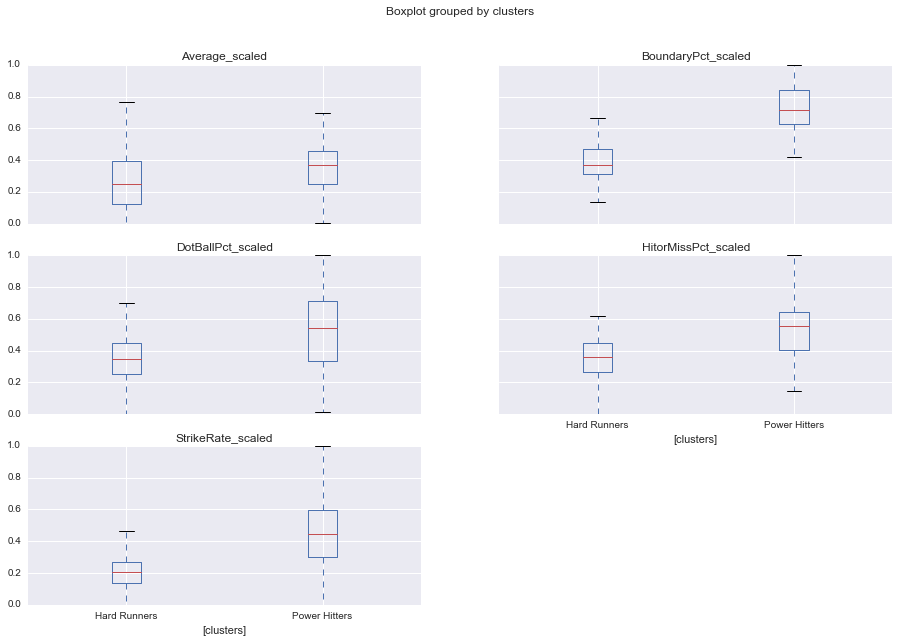

In [82]:
plt.figure()
tb_knn.drop(['average','strike_rate','boundary_percentage','hitormiss_percentage','dotball_percentage'], axis = 1).boxplot(by="clusters", figsize=(15, 10))
plt.show()

#### Andrews Curves Plot
This is an useful plot to plot multivariate data as a large number of curves. By coloring these curves differently we can see if the classes(clusters) of data is easily distinguishable from their features. Looks like we can feature set does segment the data well that a classifier can be build to classify other batsmen as Power Hitters or Hard Runners from their stats.

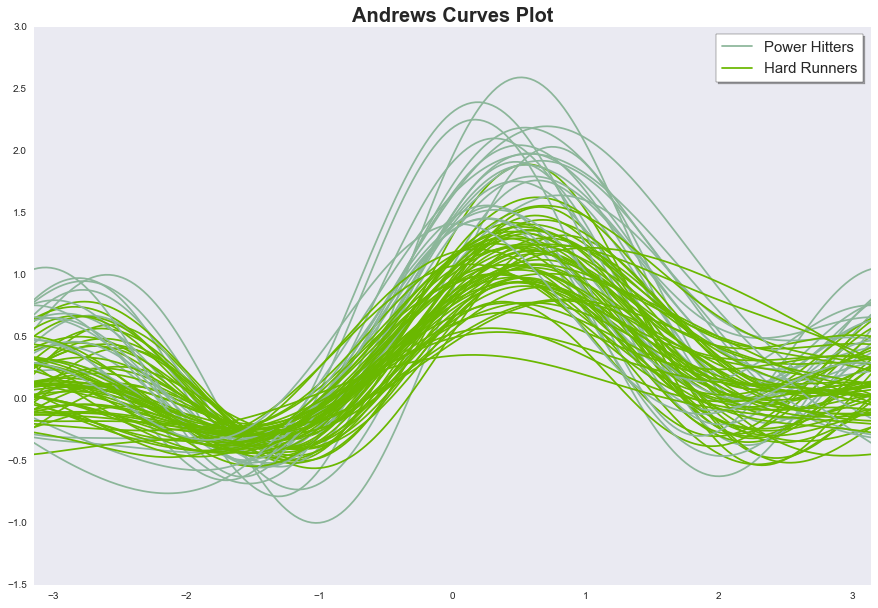

In [55]:
from pandas.plotting import andrews_curves
plt.figure(figsize=(15,10))
andrews_curves(tb_knn.drop(['boundary_pct','dotball_pct','hitmiss_pct','average','strike_rate'], axis=1), "clusters")
plt.title('Andrews Curves Plot', fontsize=20, fontweight='bold')
plt.legend(loc=1, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()

#### 3D visualization

Can we distinguish the clusters across 3 dimensions that have provided the maximum differetiation? The 3D visualization does show a clear segmentation of the Power Hitter across Boundary Percentage, HitorMiss_Percentage and Strike Rate

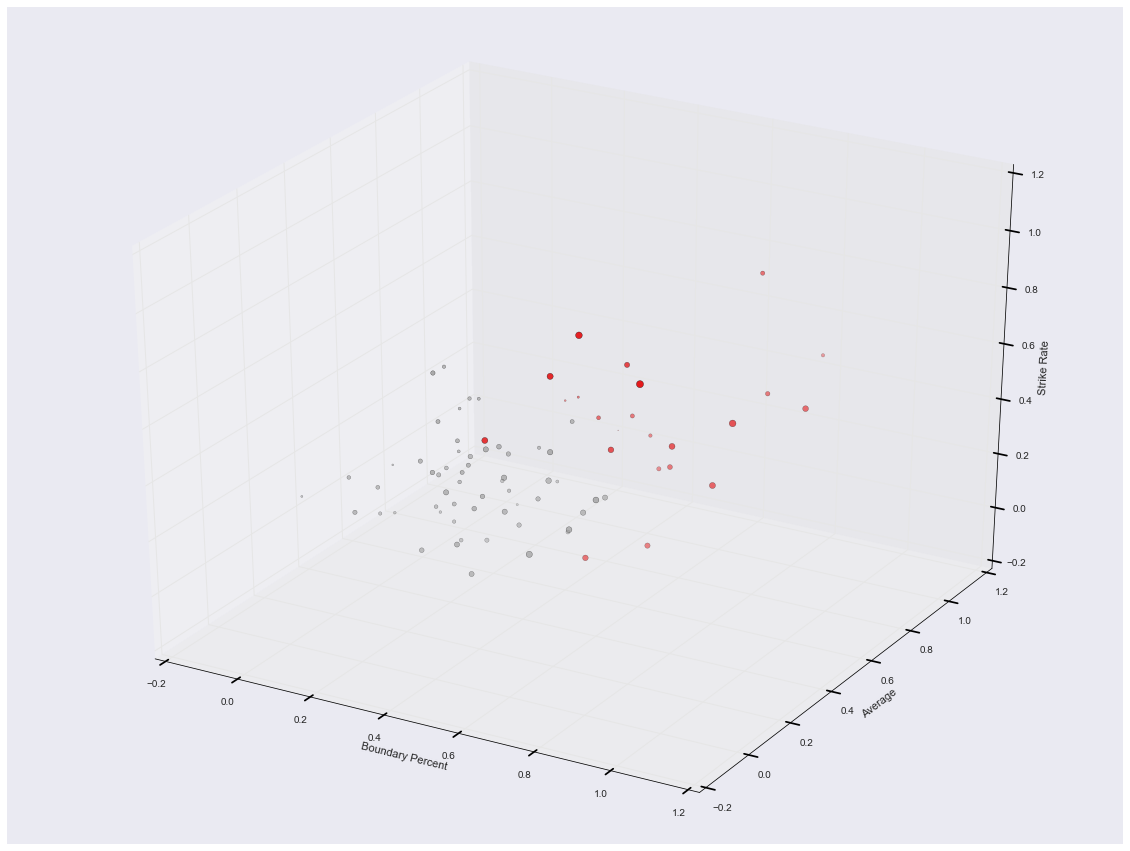

In [84]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tb_knn.loc[:,'BoundaryPct_scaled'], tb_knn.loc[:,'StrikeRate_scaled'], tb_knn.loc[:,'HitorMissPct_scaled'], c=tb_clusters,
           cmap=plt.cm.Set1, edgecolor='k', s = tb_knn.loc[:,'DotBallPct_scaled']*50)

ax.set_xlabel('Boundary Percent')
ax.set_ylabel('Average')
ax.set_zlabel('Strike Rate')

plt.show()

#### Thank you
Irrespective of where we will end up in the leaderboard of this tournament, it has been a fun learning experience for our team. We thank the sponsors for the oppurtunity and the dataset. Good luck.